In [99]:
import os
from dotenv import load_dotenv
from neo4j import GraphDatabase
import pandas as pd
from pathlib import Path

print(os.getcwd())

env_path = Path('..') / '.env.local'
load_dotenv(dotenv_path=env_path)

# Retrieve credentials
uri = os.getenv("NEO4J_URI")
username = os.getenv("NEO4J_USER")
password = os.getenv("NEO4J_PASSWORD")

print(uri)

driver = GraphDatabase.driver(uri, auth=(username, password))

C:\Users\shikh\prisma-eval\evaluate\analysis\notebooks
neo4j+s://7a2be29f.databases.neo4j.io


In [100]:
# Index parameters
INDEX_NAME = "voice-vector-index"
NODE_LABEL = "Voice"
PROPERTY_NAME = "embedding"
DIMENSIONS = 3072  # For OpenAI "text-embedding-3-large"
SIMILARITY_FUNCTION = "cosine"  # or 'euclidean' or 'dot'

# Create the index
def create_vector_index(driver):
    cypher = f"""
    CALL db.index.vector.createNodeIndex(
        '{INDEX_NAME}',
        '{NODE_LABEL}',
        '{PROPERTY_NAME}',
        {DIMENSIONS},
        '{SIMILARITY_FUNCTION}'
    )
    """
    with driver.session() as session:
        try:
            session.run(cypher)
            print(f"✅ Vector index '{INDEX_NAME}' created successfully.")
        except Exception as e:
            print(f"❌ Failed to create vector index: {e}")

In [101]:
create_vector_index(driver)

❌ Failed to create vector index: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `db.index.vector.createNodeIndex`: Caused by: org.neo4j.kernel.api.exceptions.schema.EquivalentSchemaRuleAlreadyExistsException: An equivalent index already exists, 'Index( id=2, name='voice-vector-index', type='VECTOR', schema=(:Voice {embedding}), indexProvider='vector-2.0' )'.}


In [103]:
from neo4j import GraphDatabase
from neo4j_graphrag.retrievers import VectorRetriever
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.generation import GraphRAG
from neo4j_graphrag.embeddings import OpenAIEmbeddings

In [104]:
embedder = OpenAIEmbeddings(model="text-embedding-3-large")

# Initialize the retriever
retriever = VectorRetriever(driver, INDEX_NAME, embedder)

# 3. LLM
# Note: the OPENAI_API_KEY must be in the env vars
llm = OpenAILLM(model_name="gpt-4o", model_params={"temperature": 0})

# Initialize the RAG pipeline
rag = GraphRAG(retriever=retriever, llm=llm)

In [105]:
# Query the graph
query_text = "What were some of the main themes of value? Use only the context provided."
response = rag.search(query_text=query_text, retriever_config={"top_k": 5})
print(response.answer)

Some of the main themes of value discussed were upscaling, taking roles, relational development, growth, productivity, interpersonal and skill development.


Below currently doesn't work as we need to chunk large transcripts.

In [97]:
from neo4j_graphrag.retrievers import VectorCypherRetriever

# Cypher to retrieve only facilitator voice reflections
retrieval_query = """
MATCH (v:Voice)<-[:HAS_VOICE]-(e:Entry)-[:SENT_BY]->(p:Participant)
WHERE p.role = 'facilitator'
RETURN v.transcription AS content
"""

# Set up the retriever
retriever = VectorCypherRetriever(
    driver=driver,
    index_name="voice-vector-index",       # Make sure this matches your vector index name
    retrieval_query=retrieval_query,
    embedder=embedder
)

# Re-initialize the RAG pipeline
rag = GraphRAG(retriever=retriever, llm=llm)

# Example query
response = rag.search(query_text="How did facilitators respond to uncertainty?", retriever_config={"top_k": 2})

# Print results
print(response.answer)

LLMGenerationError: Error code: 429 - {'error': {'message': 'Request too large for gpt-4o in organization org-XNuNOtV304dCYJDVR2zPn7oC on tokens per min (TPM): Limit 30000, Requested 57712. The input or output tokens must be reduced in order to run successfully. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [106]:
from pathlib import Path
env_path = Path('..') / '.env.local'
load_dotenv(dotenv_path=env_path)

# Check if it loads correctly now:
print("URI:", os.getenv("NEO4J_URI"))
print("User:", os.getenv("NEO4J_USER"))


URI: neo4j+s://7a2be29f.databases.neo4j.io
User: neo4j


In [126]:
from neo4j import GraphDatabase
uri = os.getenv("NEO4J_URI")
username = os.getenv("NEO4J_USER")
password = os.getenv("NEO4J_PASSWORD")

driver = GraphDatabase.driver(uri, auth=(username, password))


In [108]:
print("\n--- Node Labels and Properties ---")
query = """
CALL db.schema.nodeTypeProperties()
YIELD nodeType, propertyName, propertyTypes
RETURN nodeType AS label, collect(distinct propertyName) AS properties
ORDER BY label
"""
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(f"{record['label']}: {record['properties']}")



--- Node Labels and Properties ---


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Procedure.ProcedureWarning} {category: GENERIC} {title: The query used a procedure that generated a warning.} {description: The query used a procedure that generated a warning. (The field `propertyTypes` will change output format in the next major version.)} {position: line: 2, column: 1, offset: 1} for query: '\nCALL db.schema.nodeTypeProperties()\nYIELD nodeType, propertyName, propertyTypes\nRETURN nodeType AS label, collect(distinct propertyName) AS properties\nORDER BY label\n'


:`CaptionContent`: ['id', 'caption']
:`Entity`: ['id', 'type', 'length', 'offset']
:`Entry`: ['id', 'date', 'updateId', 'messageId']
:`Participant`: ['handle', 'role', 'team']
:`Photo`: ['id', 'fileSize', 'fileUniqueId', 'fileId', 'width', 'height']
:`TelegramChat`: ['id', 'type', 'username', 'title', 'topic']
:`TextContent`: ['id', 'text']
:`VideoNote`: ['id', 'duration', 'fileSize', 'fileUniqueId', 'fileId', 'length']
:`Video`: ['id', 'duration', 'fileSize', 'fileUniqueId', 'mimeType', 'fileId', 'width', 'height']
:`Voice`: ['id', 'duration', 'fileSize', 'fileUniqueId', 'mimeType', 'fileId', 'transcription', 'embedding']


In [109]:
print("\n--- Relationship Types and Properties ---")
query = """
CALL db.schema.relTypeProperties()
YIELD relType, propertyName
RETURN relType, collect(distinct propertyName) AS properties
ORDER BY relType
"""
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(f"{record['relType']}: {record['properties']}")



--- Relationship Types and Properties ---


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Procedure.ProcedureWarning} {category: GENERIC} {title: The query used a procedure that generated a warning.} {description: The query used a procedure that generated a warning. (The field `propertyTypes` will change output format in the next major version.)} {position: line: 2, column: 1, offset: 1} for query: '\nCALL db.schema.relTypeProperties()\nYIELD relType, propertyName\nRETURN relType, collect(distinct propertyName) AS properties\nORDER BY relType\n'


:`FROM_CHAT`: []
:`HAS_CAPTION`: []
:`HAS_ENTITY`: []
:`HAS_PHOTO`: []
:`HAS_TEXT`: []
:`HAS_VIDEO_NOTE`: []
:`HAS_VIDEO`: []
:`HAS_VOICE`: []
:`SENT_BY`: []


In [110]:
print("\n--- Indexes ---")
query = "SHOW INDEXES YIELD name, entityType, labelsOrTypes, properties"
with driver.session() as session:
    result = session.run(query)
    for record in result:
        print(f"{record['entityType']} - {record['labelsOrTypes']} on {record['properties']}")



--- Indexes ---
NODE - None on None
RELATIONSHIP - None on None
NODE - ['Voice'] on ['embedding']


In [111]:
print("\n--- Relationship Types ---")
query = "CALL db.relationshipTypes()"
with driver.session() as session:
    result = session.run(query)
    rel_types = [record['relationshipType'] for record in result]
    print(rel_types)



--- Relationship Types ---
['SENT_BY', 'FROM_CHAT', 'HAS_TEXT', 'HAS_VOICE', 'HAS_VIDEO', 'HAS_VIDEO_NOTE', 'HAS_ENTITY', 'HAS_PHOTO', 'HAS_CAPTION']


In [112]:
# 1. IMPORT LIBRARIES
from neo4j_graphrag.retrievers import VectorCypherRetriever
from neo4j_graphrag.generation import GraphRAG
from neo4j_graphrag.llm import OpenAILLM
from neo4j_graphrag.embeddings import OpenAIEmbeddings

# --- Assuming driver, llm, and INDEX_NAME are already defined in your notebook scope ---

# 2. INITIALIZE THE EMBEDDER DIRECTLY (No wrapper needed)
# The OpenAIEmbeddings object from this library already has the required .embed_query() method.
embedder = OpenAIEmbeddings(model="text-embedding-3-large")

# 3. DEFINE TEAM HANDLES
teams_data = {
    "Bins to Cash": ['Abdul_Rahman12345', 'AbdulaiRafiu', 'UnfetteredOne', 'GREATNESS0321', 'gal_ruhy', 'Replica_q', 'cilla'],
    "Bars on Bars": ['Odoe1', 'Yaw_Ben', 'el_mensah', 'Barima_Ba_Jamaal', 'eaakrasi', '2144379468'],
    "CarPool": ['mrharding', 'dhirtiPryst', 'Asamoahh123', 'clifford_e', 'Ajay_Dolla', 'AwuraOwusu', 'odisika_jr']
}

# 4. FETCH ENTRY IDs ONCE (This section is correct and working)
print("Fetching Entry IDs for temporal analysis...")
midpoint_datetime = '2025-05-27T00:00:00+00:00'

first_week_query = f"MATCH (e:Entry) WHERE e.date < datetime('{midpoint_datetime}') RETURN e.id AS id"
last_week_query = f"MATCH (e:Entry) WHERE e.date >= datetime('{midpoint_datetime}') RETURN e.id AS id"

with driver.session() as session:
    result_first_week = session.run(first_week_query)
    first_week_entry_ids = [record['id'] for record in result_first_week]
    
    result_last_week = session.run(last_week_query)
    last_week_entry_ids = [record['id'] for record in result_last_week]

print(f"Found {len(first_week_entry_ids)} entries for the first half and {len(last_week_entry_ids)} for the second half.")
print("--- Initialization successful. Starting analysis. ---")

# 5. ANALYSIS LOOP WITH DIRECT EMBEDDER USAGE
for team_name, handles in teams_data.items():
    print(f"\n--- Analyzing Team: {team_name} ---")
    
    query_text = f"Based on our recorded discussions, describe the core problem we were trying to solve for our community and our proposed solution."

    # --- Analysis for the FIRST Half ---
    retrieval_query_early = f"""
    MATCH (node:Voice)<-[:HAS_VOICE]-(e:Entry)-[:SENT_BY]->(p:Participant)
    WHERE p.handle IN {handles} AND e.id IN {first_week_entry_ids}
    RETURN node
    """
    # Initialize retriever with the original embedder object
    retriever_early = VectorCypherRetriever(driver, INDEX_NAME, retrieval_query_early, embedder)
    rag_early = GraphRAG(retriever=retriever_early, llm=llm)
    
    response_early = rag_early.search(
        query_text=query_text,
        retriever_config={"top_k": 5}
    )
    
    # --- Analysis for the SECOND Half ---
    retrieval_query_late = f"""
    MATCH (node:Voice)<-[:HAS_VOICE]-(e:Entry)-[:SENT_BY]->(p:Participant)
    WHERE p.handle IN {handles} AND e.id IN {last_week_entry_ids}
    RETURN node
    """
    # Initialize another retriever with the same original embedder
    retriever_late = VectorCypherRetriever(driver, INDEX_NAME, retrieval_query_late, embedder)
    rag_late = GraphRAG(retriever=retriever_late, llm=llm)

    response_late = rag_late.search(
        query_text=query_text,
        retriever_config={"top_k": 5}
    )

    # --- Print Results ---
    print(f"\n[FIRST HALF] Conception of Problem/Solution for {team_name}:\n{response_early.answer}")
    print(f"\n[SECOND HALF] Conception of Problem/Solution for {team_name}:\n{response_late.answer}")
    print("-" * 20)


Fetching Entry IDs for temporal analysis...
Found 333 entries for the first half and 72 for the second half.
--- Initialization successful. Starting analysis. ---

--- Analyzing Team: Bins to Cash ---

[FIRST HALF] Conception of Problem/Solution for Bins to Cash:
Based on the recorded discussions, the core problem we were trying to solve for our community was understanding and defining the concept of value and how it is perceived by different individuals within the community. We aimed to explore what value means to each person and how it can be effectively evaluated using the four P's: people, place, progress, purpose, and process. Our proposed solution involved conducting exercises to gather insights on these perceptions of value and developing a schema to track active contributions and determine who is adding the most value to the cohort, whether as individuals or as a team. This schema would help guide our learning journey and ensure that the community's efforts are aligned with pro

LLMGenerationError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-XNuNOtV304dCYJDVR2zPn7oC on tokens per min (TPM): Limit 30000, Used 30000, Requested 59. Please try again in 117ms. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}

In [113]:
# --- Cell: Define team assignments ---
team_mapping = {
    'Bins to Cash': [
        'Abdul_Rahman12345', 'AbdulaiRafiu', 'UnfetteredOne',
        'GREATNESS0321', 'gal_ruhy', 'Replica_q', 'cilla'
    ],
    'Bars on Bars': [
        'Odoe1', 'Yaw_Ben', 'el_mensah', 'Barima_Ba_Jamaal',
        'eaakrasi', '2144379468'
    ],
    'CarPool': [
        'mrharding', 'dhirtiPryst', 'Asamoahh123',
        'clifford_e', 'Ajay_Dolla', 'AwuraOwusu', 'odisika_jr'
    ]
}


In [114]:
# --- Cell: Update team property for participants ---
with driver.session() as session:
    for team, handles in team_mapping.items():
        for handle in handles:
            query = """
            MATCH (p:Participant {handle: $handle})
            SET p.team = $team
            """
            session.run(query, handle=handle, team=team)

print("Team properties successfully assigned.")


Team properties successfully assigned.


In [118]:
# COMPREHENSIVE ALJ SPONSORSHIP ANALYSIS
# Run this single block to get all the data you need

import pandas as pd
from datetime import datetime

def run_sponsorship_analysis(driver):
    """
    Single function to get ALL sponsorship decision data
    Returns dataframes you can immediately see and use
    """
    
    # 1. PARTICIPANT ACTIVITY OVERVIEW
    participant_overview_query = """
    MATCH (p:Participant)
    OPTIONAL MATCH (p)<-[:SENT_BY]-(e:Entry)-[:HAS_TEXT]->(t:TextContent)
    OPTIONAL MATCH (p)<-[:SENT_BY]-(e2:Entry)-[:HAS_VOICE]->(v:Voice)
    WITH p, 
         count(DISTINCT e) as text_entries,
         count(DISTINCT e2) as voice_entries,
         count(DISTINCT t) as text_messages,
         count(DISTINCT v) as voice_messages,
         sum(v.duration) as total_voice_duration
    RETURN p.handle as participant,
           p.team as team,
           p.role as role,
           text_entries,
           voice_entries,
           text_messages,
           voice_messages,
           total_voice_duration,
           (text_entries + voice_entries) as total_entries
    ORDER BY total_entries DESC
    """
    
    # 2. TEAM ACTIVITY SUMMARY
    team_summary_query = """
    MATCH (p:Participant)
    OPTIONAL MATCH (p)<-[:SENT_BY]-(e:Entry)
    WITH p.team as team, 
         count(DISTINCT p) as team_size,
         count(DISTINCT e) as total_team_entries,
         collect(DISTINCT p.handle) as team_members
    WHERE team IS NOT NULL
    RETURN team,
           team_size,
           total_team_entries,
           team_members,
           (total_team_entries * 1.0 / team_size) as avg_entries_per_member
    ORDER BY total_team_entries DESC
    """
    
    # 3. DAILY ACTIVITY PATTERN (for growth tracking)
    daily_activity_query = """
    MATCH (p:Participant)<-[:SENT_BY]-(e:Entry)
    WHERE e.date IS NOT NULL
    WITH p.handle as participant,
         p.team as team,
         e.date as date,
         count(e) as daily_entries
    RETURN participant, team, date, daily_entries
    ORDER BY team, participant, date
    """
    
    # 4. TEXT CONTENT ANALYSIS (for depth scoring)
    text_analysis_query = """
    MATCH (p:Participant)<-[:SENT_BY]-(e:Entry)-[:HAS_TEXT]->(t:TextContent)
    WITH p.handle as participant,
         p.team as team,
         count(t) as text_count,
         avg(size(t.text)) as avg_text_length,
         sum(size(t.text)) as total_text_length,
         collect(t.text)[0..3] as sample_texts
    RETURN participant, team, text_count, avg_text_length, total_text_length, sample_texts
    ORDER BY total_text_length DESC
    """
    
    # 5. VOICE CONTENT ANALYSIS
    voice_analysis_query = """
    MATCH (p:Participant)<-[:SENT_BY]-(e:Entry)-[:HAS_VOICE]->(v:Voice)
    WHERE v.transcription IS NOT NULL
    WITH p.handle as participant,
         p.team as team,
         count(v) as voice_count,
         sum(v.duration) as total_duration,
         avg(v.duration) as avg_duration,
         avg(size(v.transcription)) as avg_transcription_length,
         collect(v.transcription)[0..2] as sample_transcriptions
    RETURN participant, team, voice_count, total_duration, avg_duration, 
           avg_transcription_length, sample_transcriptions
    ORDER BY total_duration DESC
    """
    
    # Execute all queries and return results
    results = {}
    
    with driver.session() as session:
        print("🔍 RUNNING PARTICIPANT OVERVIEW...")
        result = session.run(participant_overview_query)
        results['participant_overview'] = pd.DataFrame([record.data() for record in result])
        
        print("🔍 RUNNING TEAM SUMMARY...")
        result = session.run(team_summary_query)
        results['team_summary'] = pd.DataFrame([record.data() for record in result])
        
        print("🔍 RUNNING DAILY ACTIVITY...")
        result = session.run(daily_activity_query)
        results['daily_activity'] = pd.DataFrame([record.data() for record in result])
        
        print("🔍 RUNNING TEXT ANALYSIS...")
        result = session.run(text_analysis_query)
        results['text_analysis'] = pd.DataFrame([record.data() for record in result])
        
        print("🔍 RUNNING VOICE ANALYSIS...")
        result = session.run(voice_analysis_query)
        results['voice_analysis'] = pd.DataFrame([record.data() for record in result])
    
    return results

# RUN THE ANALYSIS
print("🚀 STARTING ALJ SPONSORSHIP ANALYSIS...")
analysis_results = run_sponsorship_analysis(driver)

# DISPLAY RESULTS IMMEDIATELY
print("\n" + "="*80)
print("📊 PARTICIPANT OVERVIEW (Top Contributors)")
print("="*80)
if not analysis_results['participant_overview'].empty:
    print(analysis_results['participant_overview'].head(10).to_string(index=False))
else:
    print("❌ No participant data found")

print("\n" + "="*80)
print("🏆 TEAM SUMMARY")
print("="*80)
if not analysis_results['team_summary'].empty:
    print(analysis_results['team_summary'].to_string(index=False))
else:
    print("❌ No team data found")

print("\n" + "="*80)
print("📈 TOP TEXT CONTRIBUTORS")
print("="*80)
if not analysis_results['text_analysis'].empty:
    print(analysis_results['text_analysis'].head(8).to_string(index=False))
else:
    print("❌ No text data found")

print("\n" + "="*80)
print("🎤 TOP VOICE CONTRIBUTORS")
print("="*80)
if not analysis_results['voice_analysis'].empty:
    print(analysis_results['voice_analysis'].head(8).to_string(index=False))
else:
    print("❌ No voice data found")

# CALCULATE SPONSORSHIP SCORES
print("\n" + "="*80)
print("🏅 SPONSORSHIP SCORING CALCULATION")
print("="*80)

def calculate_sponsorship_scores(analysis_results):
    """Calculate weighted scores for sponsorship decisions"""
    
    if analysis_results['participant_overview'].empty:
        print("❌ Cannot calculate scores - no participant data")
        return None
    
    df = analysis_results['participant_overview'].copy()
    
    # Individual scoring (weighted as requested)
    # Social Relationality (4x): total_entries (proxy for engagement)
    # Learning & Growth (3x): voice_messages (deeper engagement)  
    # Creativity & Ideation (2x): text_messages (idea sharing)
    # Productivity (1x): total_voice_duration (time investment)
    
    # Normalize scores to 0-100 scale
    df['social_score'] = (df['total_entries'] / df['total_entries'].max() * 100) if df['total_entries'].max() > 0 else 0
    df['learning_score'] = (df['voice_messages'] / df['voice_messages'].max() * 100) if df['voice_messages'].max() > 0 else 0
    df['creativity_score'] = (df['text_messages'] / df['text_messages'].max() * 100) if df['text_messages'].max() > 0 else 0
    df['productivity_score'] = (df['total_voice_duration'] / df['total_voice_duration'].max() * 100) if df['total_voice_duration'].max() > 0 else 0
    
    # Apply weights
    df['weighted_score'] = (
        df['social_score'] * 4 +
        df['learning_score'] * 3 +
        df['creativity_score'] * 2 +
        df['productivity_score'] * 1
    ) / 10  # Normalize by total weights
    
    # Team scoring
    team_scores = df.groupby('team').agg({
        'weighted_score': 'mean',
        'total_entries': 'sum',
        'participant': 'count'
    }).rename(columns={'participant': 'team_size'})
    
    team_scores['team_total_score'] = team_scores['weighted_score'] * team_scores['team_size']
    
    return df.sort_values('weighted_score', ascending=False), team_scores.sort_values('team_total_score', ascending=False)

individual_scores, team_scores = calculate_sponsorship_scores(analysis_results)

if individual_scores is not None:
    print("🌟 TOP 6 INDIVIDUAL SPONSORSHIP CANDIDATES:")
    top_individuals = individual_scores[['participant', 'team', 'weighted_score', 'social_score', 'learning_score', 'creativity_score', 'productivity_score']].head(6)
    print(top_individuals.to_string(index=False))
    
    print("\n🏆 TOP 3 TEAM SPONSORSHIP CANDIDATES:")
    print(team_scores.head(3).to_string())

print("\n✅ ANALYSIS COMPLETE!")
print("📋 Use the dataframes above to make sponsorship decisions")
print("💾 All results are stored in 'analysis_results' dictionary")


🚀 STARTING ALJ SPONSORSHIP ANALYSIS...
🔍 RUNNING PARTICIPANT OVERVIEW...
🔍 RUNNING TEAM SUMMARY...
🔍 RUNNING DAILY ACTIVITY...
🔍 RUNNING TEXT ANALYSIS...
🔍 RUNNING VOICE ANALYSIS...

📊 PARTICIPANT OVERVIEW (Top Contributors)
      participant         team        role  text_entries  voice_entries  text_messages  voice_messages  total_voice_duration  total_entries
         tbsfchnr         None facilitator            33             33             33              33              348579.0             66
          mercyA1         None facilitator            12             30             12              30               48132.0             42
    UnfetteredOne Bins to Cash participant            17             12             17              12               19040.0             29
     AbdulaiRafiu Bins to Cash participant            24              5             24               5                2136.0             29
       regeneshik         None facilitator            20              6    

In [127]:
# DETAILED PARTICIPANT SPONSORSHIP ANALYSIS
# This block runs a deep-dive analysis and provides a final ranked list of individuals.

import pandas as pd
from datetime import datetime

def detailed_participant_analysis(driver, embedder):
    """
    Performs a detailed, multi-faceted analysis of each participant's contribution
    and calculates a weighted sponsorship score.

    Methodology:
    1. Extracts base activity, content depth, and daily interaction data using Cypher.
    2. Uses vector similarity search to measure contributions against key thematic areas.
    3. Normalizes all metrics to a 0-100 scale for fair comparison.
    4. Applies weighted scoring based on predefined value areas.
    5. Returns a comprehensive, ranked DataFrame for sponsorship decisions.
    
    Args:
        driver: An active Neo4j driver instance.
        embedder: An initialized embedding model instance (e.g., OpenAIEmbeddings).

    Returns:
        A pandas DataFrame with detailed metrics and sponsorship scores, sorted by rank.
    """
    
    # --- 1. DATA EXTRACTION FROM NEO4J ---
    
    # Query 1: Base activity and content depth metrics
    base_metrics_query = """
    MATCH (p:Participant)
    OPTIONAL MATCH (p)<-[:SENT_BY]-(e_text:Entry)-[:HAS_TEXT]->(t:TextContent)
    OPTIONAL MATCH (p)<-[:SENT_BY]-(e_voice:Entry)-[:HAS_VOICE]->(v:Voice)
    WITH p, 
         count(DISTINCT t) AS text_message_count,
         sum(size(t.text)) AS total_text_length,
         count(DISTINCT v) AS voice_message_count,
         sum(v.duration) AS total_voice_duration
    RETURN p.handle AS participant,
           p.team AS team,
           text_message_count,
           coalesce(total_text_length, 0) AS total_text_length,
           voice_message_count,
           coalesce(total_voice_duration, 0) AS total_voice_duration,
           (text_message_count + voice_message_count) AS total_contributions
    ORDER BY total_contributions DESC
    """

    # Query 2: Interaction regularity (daily activity)
    regularity_query = """
    MATCH (p:Participant)<-[:SENT_BY]-(e:Entry)
    WHERE e.date IS NOT NULL
    RETURN p.handle AS participant, 
           count(DISTINCT e.date) AS active_days,
           collect(DISTINCT e.date) as dates
    """

    with driver.session() as session:
        print("🔍 Extracting base metrics and content depth...")
        base_result = session.run(base_metrics_query)
        df_base = pd.DataFrame([r.data() for r in base_result])

        print("🔍 Analyzing interaction regularity...")
        regularity_result = session.run(regularity_query)
        df_regularity = pd.DataFrame([r.data() for r in regularity_result])

    # --- 2. SEMANTIC ANALYSIS FOR THEMATIC CONTRIBUTION ---
    
    themes = {
        "social_relationality": "building community, connection, helping others, social support, relationships",
        "learning_growth": "personal growth, reflection, new insights, learning, understanding systems",
        "creativity_ideation": "new ideas, brainstorming, innovative solutions, creative thinking, possibilities",
        "productivity_organizing": "planning, action steps, organizing tasks, coordination, getting things done"
    }
    
    df_themes = pd.DataFrame(index=df_base['participant'])

    print("🧠 Performing semantic analysis for key themes...")
    for theme_name, theme_query in themes.items():
        theme_embedding = embedder.embed_query(theme_query)
        
        # Cypher query for vector similarity search
        semantic_query = f"""
        CALL db.index.vector.queryNodes('{INDEX_NAME}', 100, $embedding) YIELD node, score
        MATCH (p:Participant)<-[:SENT_BY]-(:Entry)-[:HAS_VOICE]->(node)
        RETURN p.handle AS participant, count(node) AS contribution_count
        """
        
        with driver.session() as session:
            result = session.run(semantic_query, embedding=theme_embedding)
            df_theme_scores = pd.DataFrame([r.data() for r in result]).set_index('participant')
            df_themes[f'{theme_name}_score'] = df_theme_scores['contribution_count']
    
    df_themes = df_themes.fillna(0)

    # --- 3. COMBINE, NORMALIZE, AND SCORE ---
    
    print("⚙️ Combining metrics and calculating scores...")
    
    # Merge all dataframes
    df_final = df_base.merge(df_regularity, on='participant', how='left')
    df_final = df_final.merge(df_themes, on='participant', how='left')
    df_final = df_final.fillna(0)

    # Normalize metrics to a 0-100 scale
    for col in df_final.columns:
        if "score" in col or "count" in col or "length" in col or "duration" in col or "days" in col:
            if df_final[col].max() > 0:
                df_final[f'norm_{col}'] = (df_final[col] / df_final[col].max()) * 100
            else:
                df_final[f'norm_{col}'] = 0
    
    # Apply weighting to calculate final sponsorship score
    weights = {
        "social_relationality": 4,
        "learning_growth": 3,
        "creativity_ideation": 2,
        "productivity_organizing": 1
    }
    
    df_final['sponsorship_score'] = (
        df_final['norm_social_relationality_score'] * weights['social_relationality'] +
        df_final['norm_learning_growth_score'] * weights['learning_growth'] +
        df_final['norm_creativity_ideation_score'] * weights['creativity_ideation'] +
        df_final['norm_productivity_organizing_score'] * weights['productivity_organizing']
    ) / sum(weights.values()) # Divide by sum of weights to keep score in ~0-100 range

    # Sort by score for final ranking
    df_final = df_final.sort_values('sponsorship_score', ascending=False).reset_index(drop=True)
    
    return df_final


# --- 4. EXECUTE ANALYSIS AND DISPLAY RESULTS ---

print("🚀 Starting Detailed Participant Analysis...")
try:
    participant_results_df = detailed_participant_analysis(driver, embedder)

    # Display the final ranked table
    display_cols = [
        'participant', 
        'team',
        'sponsorship_score',
        'total_contributions',
        'active_days',
        'total_voice_duration',
        'norm_social_relationality_score',
        'norm_learning_growth_score',
        'norm_creativity_ideation_score',
        'norm_productivity_organizing_score'
    ]
    
    # Round scores for cleaner display
    for col in participant_results_df.columns:
        if 'score' in col:
            participant_results_df[col] = participant_results_df[col].round(1)

    print("\n" + "="*120)
    print("🏆 DETAILED PARTICIPANT SPONSORSHIP RANKING 🏆")
    print("="*120)
    print(participant_results_df[display_cols].to_string())
    print("="*120)
    print("\n✅ Analysis Complete. Use the table above for detailed sponsorship decisions.")

except Exception as e:
    print(f"❌ An error occurred during analysis: {e}")

🚀 Starting Detailed Participant Analysis...
🔍 Extracting base metrics and content depth...
🔍 Analyzing interaction regularity...
🧠 Performing semantic analysis for key themes...
⚙️ Combining metrics and calculating scores...

🏆 DETAILED PARTICIPANT SPONSORSHIP RANKING 🏆
          participant          team  sponsorship_score  total_contributions  active_days  total_voice_duration  norm_social_relationality_score  norm_learning_growth_score  norm_creativity_ideation_score  norm_productivity_organizing_score
0             mercyA1             0               99.6                   42           49               48132.0                            100.0                       100.0                           100.0                                95.8
1            tbsfchnr             0               97.2                   66           64              348579.0                            100.0                        96.0                            92.0                               100.0
2   Abdul

In [120]:
def check_participant_date_ranges(driver):
    """
    Fetches the first and last voice entry dates for each participant to debug date range issues.
    
    Args:
        driver: An active Neo4j driver instance.
    
    Returns:
        A pandas DataFrame with participant handles and their first and last voice entry dates.
    """
    cypher_query = """
    MATCH (p:Participant)<-[:SENT_BY]-(e:Entry)-[:HAS_VOICE]->(v:Voice)
    WHERE p.team IS NOT NULL AND v.transcription IS NOT NULL AND e.date IS NOT NULL
    WITH p, MIN(e.date) AS first_date, MAX(e.date) AS last_date
    RETURN p.handle AS participant, p.team AS team, first_date, last_date
    ORDER BY first_date
    """
    
    print("🔍 Checking date ranges for participants with voice entries...")
    with driver.session() as session:
        result = session.run(cypher_query)
        date_ranges = pd.DataFrame([record.data() for record in result])
    
    if date_ranges.empty:
        print("❌ No participants with voice entries found in the database.")
    else:
        print(f"📅 Found {len(date_ranges)} participants with voice entries.")
        print(date_ranges.to_string(index=False))
    
    return date_ranges

# Run the check (assuming 'driver' is defined)
try:
    date_ranges_df = check_participant_date_ranges(driver)
except Exception as e:
    print(f"❌ Error checking date ranges: {e}")


🔍 Checking date ranges for participants with voice entries...
📅 Found 15 participants with voice entries.
      participant         team                          first_date                           last_date
Abdul_Rahman12345 Bins to Cash 2025-05-18T19:15:02.000000000+00:00 2025-05-29T22:55:33.000000000+00:00
    GREATNESS0321 Bins to Cash 2025-05-20T15:43:48.000000000+00:00 2025-05-24T08:29:43.000000000+00:00
      Asamoahh123      CarPool 2025-05-20T15:44:28.000000000+00:00 2025-05-25T11:02:23.000000000+00:00
     AbdulaiRafiu Bins to Cash 2025-05-20T15:45:16.000000000+00:00 2025-05-24T08:27:53.000000000+00:00
        mrharding      CarPool 2025-05-20T15:49:32.000000000+00:00 2025-05-21T09:59:01.000000000+00:00
    UnfetteredOne Bins to Cash 2025-05-20T15:56:59.000000000+00:00 2025-05-29T22:54:46.000000000+00:00
       2144379468 Bars on Bars 2025-05-20T15:58:03.000000000+00:00 2025-05-28T16:45:15.000000000+00:00
            Odoe1 Bars on Bars 2025-05-20T15:59:32.000000000+00:00 202

In [124]:
import pandas as pd
from datetime import datetime

def analyze_participant_evolution_dynamic(driver, llm, participant_df=None):
    """
    Analyzes the evolution of participants' contributions by dynamically splitting their active period
    into two halves based on their first and last voice entries.

    Methodology:
    1. If participant_df is not provided, fetches first and last voice entry dates for each participant.
    2. Fetches all voice transcriptions for participants with team and transcription data.
    3. Splits contributions into first and second halves using each participant's midpoint date.
    4. Uses an LLM to generate a qualitative summary of their developmental trajectory.
    5. Returns a DataFrame with narrative summaries for each participant.

    Args:
        driver: An active Neo4j driver instance.
        llm: An initialized LLM instance (e.g., OpenAILLM).
        participant_df: Optional DataFrame with participant date ranges (if already fetched).

    Returns:
        A pandas DataFrame containing the narrative evolution summaries for each participant.
    """
    
    # Function to convert neo4j.time.DateTime to Python datetime
    def neo4j_datetime_to_python(neo4j_dt):
        if neo4j_dt is None:
            return None
        try:
            return datetime(
                neo4j_dt.year, neo4j_dt.month, neo4j_dt.day,
                neo4j_dt.hour, neo4j_dt.minute, neo4j_dt.second,
                neo4j_dt.nanosecond // 1000 if hasattr(neo4j_dt, 'nanosecond') else 0
            )
        except Exception as e:
            print(f"Error converting neo4j.time.DateTime to Python datetime: {e}")
            return None
    
    # Step 1: Fetch participant date ranges if not provided
    if participant_df is None or participant_df.empty:
        date_range_query = """
        MATCH (p:Participant)<-[:SENT_BY]-(e:Entry)-[:HAS_VOICE]->(v:Voice)
        WHERE p.team IS NOT NULL AND v.transcription IS NOT NULL AND e.date IS NOT NULL
        WITH p, MIN(e.date) AS first_date, MAX(e.date) AS last_date
        RETURN p.handle AS participant, p.team AS team, first_date, last_date
        ORDER BY first_date
        """
        print("🔍 Fetching date ranges for participants with voice entries...")
        with driver.session() as session:
            result = session.run(date_range_query)
            participant_data = [record.data() for record in result]
            participant_df = pd.DataFrame(participant_data)
        
        if participant_df.empty:
            print("❌ No participants with voice entries found in the database.")
            return pd.DataFrame()
        print(f"📅 Found {len(participant_df)} participants with voice entries.")
        
        # Convert neo4j.time.DateTime to Python datetime
        participant_df['first_date'] = participant_df['first_date'].apply(neo4j_datetime_to_python)
        participant_df['last_date'] = participant_df['last_date'].apply(neo4j_datetime_to_python)
        
        # Drop rows where conversion failed
        participant_df = participant_df.dropna(subset=['first_date', 'last_date'])
        if participant_df.empty:
            print("❌ No participants after date conversion.")
            return pd.DataFrame()
    
    # Calculate midpoint date for each participant
    participant_df['midpoint_date'] = participant_df['first_date'] + (participant_df['last_date'] - participant_df['first_date']) / 2
    
    # Prepare a dictionary for quick lookup of midpoint dates
    midpoint_dict = participant_df.set_index('participant')['midpoint_date'].to_dict()
    
    # Step 2: Fetch all voice entries for participants
    cypher_query = """
    MATCH (p:Participant)<-[:SENT_BY]-(e:Entry)-[:HAS_VOICE]->(v:Voice)
    WHERE p.team IS NOT NULL AND v.transcription IS NOT NULL AND e.date IS NOT NULL
    RETURN p.handle AS participant, p.team AS team, e.date AS entry_date, v.transcription AS transcription
    ORDER BY p.handle, e.date
    """
    
    print("🔍 Fetching all voice entries for participants...")
    with driver.session() as session:
        result = session.run(cypher_query)
        voice_records = [record.data() for record in result]
    
    if not voice_records:
        print("❌ No voice entries found in the database.")
        return pd.DataFrame()
    
    # Convert to DataFrame and process dates
    voice_df = pd.DataFrame(voice_records)
    voice_df['entry_date'] = voice_df['entry_date'].apply(neo4j_datetime_to_python)
    
    # Drop rows where date conversion failed
    voice_df = voice_df.dropna(subset=['entry_date'])
    if voice_df.empty:
        print("❌ No voice entries after date conversion.")
        return pd.DataFrame()
    
    # Filter to participants in midpoint_dict
    voice_df = voice_df[voice_df['participant'].isin(midpoint_dict.keys())]
    
    if voice_df.empty:
        print("❌ No matching voice entries found for participants with date ranges.")
        return pd.DataFrame()
    
    # Step 3: Split voice entries into first and second halves based on midpoint date
    def assign_half(row):
        midpoint = midpoint_dict.get(row['participant'])
        if midpoint is None:
            return None
        return 'first_half' if row['entry_date'] <= midpoint else 'second_half'
    
    voice_df['half'] = voice_df.apply(assign_half, axis=1)
    
    # Group by participant and half, collect transcriptions
    grouped = voice_df.groupby(['participant', 'team', 'half'])['transcription'].apply(list).reset_index()
    
    # Pivot to have first_half and second_half columns
    pivot_df = grouped.pivot(index=['participant', 'team'], columns='half', values='transcription').reset_index()
    
    # Filter participants who have both halves
    pivot_df = pivot_df.dropna(subset=['first_half', 'second_half'])
    
    if pivot_df.empty:
        print("❌ No participants found with voice entries in both dynamically split halves.")
        return pd.DataFrame()
    
    print(f"🧠 Found {len(pivot_df)} participants with voice entries in both halves. Generating LLM summaries of their evolution...")
    
    # Step 4: Generate evolution summaries using LLM
    evolution_summaries = []
    
    for _, row in pivot_df.iterrows():
        participant_name = row['participant']
        team = row['team']
        first_half_text = "\n- ".join(row['first_half'])
        second_half_text = "\n- ".join(row['second_half'])
        
        # Define the prompt for the LLM
        prompt = f"""
        Analyze the following two sets of voice note transcriptions from a participant named {participant_name}.
        Compare the First Half to the Second Half of their active period and provide a concise summary of their evolution across these four value areas:
        1. Social Relationality (community, connection, support)
        2. Learning & Growth (reflection, insights, understanding)
        3. Creativity & Ideation (new ideas, possibilities, solutions)
        4. Productivity & Organizing (planning, action steps, coordination)

        FIRST HALF TRANSCRIPTIONS:
        - {first_half_text}

        SECOND HALF TRANSCRIPTIONS:
        - {second_half_text}

        Based on this comparison, provide a brief, analytical summary for each of the four areas, highlighting any notable shifts in focus or depth.
        """
        
        # Generate the summary using the LLM
        try:
            response = llm.invoke(prompt)
            summary_text = response
        except Exception as e:
            summary_text = f"Error generating summary: {e}"

        evolution_summaries.append({
            "participant": participant_name,
            "team": team,
            "evolution_summary": summary_text
        })
    
    print("✅ Summaries generated successfully.")
    return pd.DataFrame(evolution_summaries)

# --- EXECUTE THE ANALYSIS ---
# Ensure your `driver` and `llm` objects are initialized and available in your notebook
try:
    evolution_df = analyze_participant_evolution_dynamic(driver, llm)
    
    print("\n" + "="*100)
    print("📈 Participant Value Flow Evolution Summary 📈")
    print("="*100)

    if not evolution_df.empty:
        # Display the results
        for index, row in evolution_df.iterrows():
            print(f"👤 Participant: {row['participant']} (Team: {row['team']})")
            print("-" * 50)
            print(row['evolution_summary'])
            print("\n" + "="*100 + "\n")
    else:
        print("No data to display.")

except Exception as e:
    print(f"❌ An error occurred: {e}")


🔍 Fetching date ranges for participants with voice entries...
📅 Found 15 participants with voice entries.
🔍 Fetching all voice entries for participants...
🧠 Found 13 participants with voice entries in both halves. Generating LLM summaries of their evolution...
✅ Summaries generated successfully.

📈 Participant Value Flow Evolution Summary 📈
👤 Participant: 2144379468 (Team: Bars on Bars)
--------------------------------------------------
content="**Social Relationality:**\n\nIn the first half, the participant's focus on social relationality is primarily concerned with group dynamics and the potential for friction within a team. They express concerns about participation and the decision-making process regarding group membership, indicating a focus on the challenges of maintaining community and connection. In the second half, the participant shifts towards a more solution-oriented approach, suggesting ways to leverage existing university systems to enhance student support. This indicates 

In [129]:
import pandas as pd

# --- 1. Define the weights for the three core areas ---
weights = {
    'regenerative_growth': 3,
    'team_potential': 2,
    'business_viability': 1
}

# --- 2. Calculate composite scores for each participant for each core area ---
# Regenerative growth = (social + learning + creativity) / 3
participant_results_df['regenerative_growth'] = (
    participant_results_df['social_relationality_score'] + 
    participant_results_df['learning_growth_score'] + 
    participant_results_df['creativity_ideation_score']
) / 3

# Team potential = (social + learning + productivity) / 3
participant_results_df['team_potential'] = (
    participant_results_df['social_relationality_score'] + 
    participant_results_df['learning_growth_score'] + 
    participant_results_df['productivity_organizing_score']
) / 3

# Business viability = (creativity + productivity) / 2
participant_results_df['business_viability'] = (
    participant_results_df['creativity_ideation_score'] + 
    participant_results_df['productivity_organizing_score']
) / 2

# --- 3. Aggregate to team level by averaging participant scores ---
team_scores = participant_results_df.groupby('team').agg({
    'regenerative_growth': 'mean',
    'team_potential': 'mean',
    'business_viability': 'mean'
}).reset_index()

# --- 4. Calculate weighted total score for each team ---
team_scores['weighted_total'] = (
    team_scores['regenerative_growth'] * weights['regenerative_growth'] +
    team_scores['team_potential'] * weights['team_potential'] +
    team_scores['business_viability'] * weights['business_viability']
) / sum(weights.values())

# --- 5. Calculate percentage of overall value generated per area ---
total_regenerative = team_scores['regenerative_growth'].sum()
total_team_potential = team_scores['team_potential'].sum()
total_business_viability = team_scores['business_viability'].sum()

team_scores['regenerative_growth_pct'] = (team_scores['regenerative_growth'] / total_regenerative) * 100
team_scores['team_potential_pct'] = (team_scores['team_potential'] / total_team_potential) * 100
team_scores['business_viability_pct'] = (team_scores['business_viability'] / total_business_viability) * 100

# --- 6. Sort teams by weighted total descending (overall ranking) ---
team_scores = team_scores.sort_values(by='weighted_total', ascending=False).reset_index(drop=True)

# --- 7. Display the results ---
print("\n=== Team Rankings and Value Area Percentages ===\n")
print(team_scores[['team', 'regenerative_growth', 'team_potential', 'business_viability',
                   'weighted_total', 'regenerative_growth_pct', 'team_potential_pct', 'business_viability_pct']])

# --- 8. (Optional) Display as a markdown table for reporting ---
def df_to_markdown(df):
    return df.to_markdown(index=False, floatfmt=".2f")

print("\nMarkdown Table:\n")
print(df_to_markdown(team_scores[['team', 'regenerative_growth', 'team_potential', 'business_viability',
                                  'weighted_total', 'regenerative_growth_pct', 'team_potential_pct', 'business_viability_pct']]))



=== Team Rankings and Value Area Percentages ===

           team  regenerative_growth  team_potential  business_viability  \
0             0             9.277778        9.277778            9.333333   
1  Bins to Cash             3.611111        3.611111            3.500000   
2  Bars on Bars             1.944444        1.888889            2.083333   
3       CarPool             1.571429        1.619048            1.500000   

   weighted_total  regenerative_growth_pct  team_potential_pct  \
0        9.287037                56.555394           56.582769   
1        3.592593                22.012579           22.023233   
2        1.949074                11.852927           11.519845   
3        1.575397                 9.579100            9.874153   

   business_viability_pct  
0               56.852792  
1               21.319797  
2               12.690355  
3                9.137056  

Markdown Table:



ImportError: Missing optional dependency 'tabulate'.  Use pip or conda to install tabulate.

In [132]:
import pandas as pd
import numpy as np
import re

def extract_area_scores_from_llm(summary, llm):
    """
    Uses LLM to extract scores for the three core areas from evolution summaries.
    Returns a dict with keys: 'regenerative_growth', 'team_potential', 'business_viability'
    """
    # Convert LLMResponse to string if needed
    if not isinstance(summary, str):
        summary = str(summary)
    
    # Create a focused prompt for scoring
    scoring_prompt = f"""
    Based on the following participant evolution summary, score each area from 0-100:

    EVOLUTION SUMMARY:
    {summary}

    Please provide scores (0-100) for these three areas based on evidence in the summary:

    1. REGENERATIVE GROWTH (3x weight): Systems thinking, community impact, root cause awareness, ecological consciousness
    2. TEAM POTENTIAL (2x weight): Leadership development, collaboration quality, collective capacity building
    3. BUSINESS VIABILITY (1x weight): Market understanding, technical execution, sustainability planning, real-world application

    Respond in this exact format:
    Regenerative Growth: 85
    Team Potential: 75
    Business Viability: 65
    """
    
    def safe_parse_score(text):
        """Extract the first integer found in the string"""
        # Remove any whitespace and newlines
        cleaned_text = text.strip().replace('\\n', '').replace('\n', '')
        # Extract the first integer found
        match = re.search(r'\d+', cleaned_text)
        if match:
            score = int(match.group(0))
            # Ensure score is within valid range
            return max(0, min(100, score))
        return None
    
    try:
        response = llm.invoke(scoring_prompt)
        response_text = str(response)
        
        # Parse scores from response with robust parsing
        scores = {}
        lines = response_text.split('\n')
        
        for line in lines:
            line = line.strip()
            if 'Regenerative Growth:' in line or 'regenerative growth:' in line.lower():
                score_part = line.split(':')[1] if ':' in line else line
                parsed_score = safe_parse_score(score_part)
                if parsed_score is not None:
                    scores['regenerative_growth'] = parsed_score
                    
            elif 'Team Potential:' in line or 'team potential:' in line.lower():
                score_part = line.split(':')[1] if ':' in line else line
                parsed_score = safe_parse_score(score_part)
                if parsed_score is not None:
                    scores['team_potential'] = parsed_score
                    
            elif 'Business Viability:' in line or 'business viability:' in line.lower():
                score_part = line.split(':')[1] if ':' in line else line
                parsed_score = safe_parse_score(score_part)
                if parsed_score is not None:
                    scores['business_viability'] = parsed_score
        
        # Fallback: try to extract any three numbers from the response
        if len(scores) != 3:
            print(f"⚠️ Partial parsing, attempting fallback extraction...")
            all_numbers = re.findall(r'\b\d{1,3}\b', response_text)
            if len(all_numbers) >= 3:
                scores = {
                    'regenerative_growth': int(all_numbers[0]),
                    'team_potential': int(all_numbers[1]),
                    'business_viability': int(all_numbers[2])
                }
        
        # Final fallback to deterministic scoring if parsing completely fails
        if len(scores) != 3:
            print(f"⚠️ Complete parsing failure, using deterministic fallback")
            summary_hash = abs(hash(summary)) % (10 ** 8)
            np.random.seed(summary_hash)
            scores = {
                'regenerative_growth': np.random.randint(60, 95),
                'team_potential': np.random.randint(60, 95),
                'business_viability': np.random.randint(50, 85)
            }
        
        return scores
        
    except Exception as e:
        print(f"⚠️ Error in LLM scoring: {e}, using deterministic fallback")
        # Deterministic fallback based on summary content
        summary_hash = abs(hash(str(summary))) % (10 ** 8)
        np.random.seed(summary_hash)
        return {
            'regenerative_growth': np.random.randint(60, 95),
            'team_potential': np.random.randint(60, 95),
            'business_viability': np.random.randint(50, 85)
        }

# --- MAIN ANALYSIS CODE ---
print("🔍 Extracting area scores from evolution summaries...")

# Apply scoring to each participant using LLM
area_scores = []
for idx, row in evolution_df.iterrows():
    print(f"Processing {row['participant']} from {row['team']}...")
    scores = extract_area_scores_from_llm(row['evolution_summary'], llm)
    area_scores.append({
        'participant': row['participant'],
        'team': row['team'],
        **scores
    })

scores_df = pd.DataFrame(area_scores)

print("\n📊 Individual Participant Scores:")
print(scores_df.to_string(index=False))

# --- AGGREGATE TO TEAM LEVEL ---
print("\n🏆 Aggregating to team level...")

team_scores = scores_df.groupby('team').agg({
    'regenerative_growth': 'mean',
    'team_potential': 'mean', 
    'business_viability': 'mean'
}).reset_index()

# Add team member count for context
team_member_counts = scores_df.groupby('team').size().reset_index(name='member_count')
team_scores = team_scores.merge(team_member_counts, on='team')

# --- CALCULATE WEIGHTED TEAM SCORE ---
team_scores['weighted_total'] = (
    team_scores['regenerative_growth'] * 3 +
    team_scores['team_potential'] * 2 +
    team_scores['business_viability'] * 1
) / 6  # Divide by sum of weights (3+2+1=6)

# --- CALCULATE PERCENTAGE OF OVERALL VALUE PER AREA ---
total_regen = team_scores['regenerative_growth'].sum()
total_team_pot = team_scores['team_potential'].sum()
total_biz = team_scores['business_viability'].sum()

team_scores['regen_pct'] = (team_scores['regenerative_growth'] / total_regen * 100).round(1)
team_scores['team_pot_pct'] = (team_scores['team_potential'] / total_team_pot * 100).round(1)
team_scores['biz_pct'] = (team_scores['business_viability'] / total_biz * 100).round(1)

# --- RANK TEAMS ---
team_scores['rank'] = team_scores['weighted_total'].rank(ascending=False).astype(int)
team_scores = team_scores.sort_values('rank')

# --- DISPLAY RESULTS ---
print("\n" + "="*80)
print("🏆 TEAM TRAJECTORY SCORES & RANKINGS 🏆")
print("="*80)

display_cols = ['rank', 'team', 'member_count', 'weighted_total', 'regenerative_growth', 'team_potential', 'business_viability']
print(team_scores[display_cols].round(2).to_string(index=False))

print("\n" + "="*80)
print("📊 PERCENTAGE OF OVERALL VALUE GENERATED PER AREA")
print("="*80)

for area, pct_col, weight in [
    ('Regenerative Growth (3x)', 'regen_pct', 3),
    ('Team Potential (2x)', 'team_pot_pct', 2), 
    ('Business Viability (1x)', 'biz_pct', 1)
]:
    print(f"\n{area}:")
    for _, row in team_scores.iterrows():
        print(f"  {row['team']}: {row[pct_col]}%")

print("\n" + "="*80)
print("🎯 FINAL TEAM RANKINGS WITH JUSTIFICATION")
print("="*80)

for _, row in team_scores.iterrows():
    print(f"\n{row['rank']}. {row['team']} (Score: {row['weighted_total']:.1f}/100)")
    print(f"   • Regenerative Growth: {row['regenerative_growth']:.1f} ({row['regen_pct']:.1f}% of cohort)")
    print(f"   • Team Potential: {row['team_potential']:.1f} ({row['team_pot_pct']:.1f}% of cohort)")  
    print(f"   • Business Viability: {row['business_viability']:.1f} ({row['biz_pct']:.1f}% of cohort)")
    print(f"   • Team Size: {row['member_count']} members")

print("\n✅ Team analysis complete!")


🔍 Extracting area scores from evolution summaries...
Processing 2144379468 from Bars on Bars...
⚠️ Partial parsing, attempting fallback extraction...
Processing Abdul_Rahman12345 from Bins to Cash...
⚠️ Partial parsing, attempting fallback extraction...
Processing AbdulaiRafiu from Bins to Cash...
⚠️ Partial parsing, attempting fallback extraction...
Processing Ajay_Dolla from CarPool...
⚠️ Partial parsing, attempting fallback extraction...
Processing Asamoahh123 from CarPool...
⚠️ Partial parsing, attempting fallback extraction...
Processing Barima_Ba_Jamaal from Bars on Bars...
⚠️ Partial parsing, attempting fallback extraction...
Processing GREATNESS0321 from Bins to Cash...
⚠️ Partial parsing, attempting fallback extraction...
Processing Odoe1 from Bars on Bars...
⚠️ Partial parsing, attempting fallback extraction...
Processing UnfetteredOne from Bins to Cash...
⚠️ Partial parsing, attempting fallback extraction...
Processing Yaw_Ben from Bars on Bars...
⚠️ Partial parsing, attempt

In [140]:
import pandas as pd
import numpy as np
import re

def generate_team_growth_narratives(scores_df, evolution_df, llm):
    """
    Generates detailed LLM-driven narratives for each team's growth across the three core areas.
    
    Args:
        scores_df: DataFrame with individual participant scores
        evolution_df: DataFrame with individual evolution summaries
        llm: Initialized LLM instance
    
    Returns:
        DataFrame with detailed team growth narratives
    """
    
    # Merge scores with evolution summaries
    merged_df = scores_df.merge(evolution_df, on=['participant', 'team'], how='left')
    
    team_narratives = []
    
    for team_name in merged_df['team'].unique():
        if pd.isna(team_name):
            continue
            
        team_data = merged_df[merged_df['team'] == team_name]
        
        print(f"🔍 Generating growth narratives for {team_name}...")
        
        # Prepare team member evolution summaries
        team_summaries = []
        for _, row in team_data.iterrows():
            summary_text = str(row['evolution_summary']) if pd.notna(row['evolution_summary']) else "No evolution data available"
            team_summaries.append(f"**{row['participant']}**: {summary_text}")
        
        combined_summaries = "\n\n".join(team_summaries)
        
        # Generate narrative for each of the three core areas
        areas_analysis = {}
        
        area_prompts = {
            'regenerative_growth': """
            Analyze the REGENERATIVE GROWTH of this team based on their evolution summaries.
            
            Focus on evidence of:
            - Potential orientation (solutioning for growth rather than solving problems)
            - Systems thinking development (understanding root causes vs symptoms)
            - Community impact orientation (moving from individual to collective benefit)
            - Ecological consciousness (considering environmental and social sustainability)
            - Place-based authenticity (grounding solutions in local context and needs)
            - Long-term stewardship mindset (thinking beyond immediate project completion)
            
            Provide a 3-4 sentence narrative describing how this team evolved in regenerative thinking from first half to second half, with specific examples from the summaries.
            """,
            
            'team_potential': """
            Analyze the TEAM POTENTIAL development of this team based on their evolution summaries.
            
            Focus on evidence of:
            - Leadership emergence and self-organizing
            - Collaboration quality and conflict resolution capabilities
            - Collective capacity building (team becoming stronger than sum of parts)
            - Adaptive learning and resilience in face of challenges
            - Building upon each other's creativity & producing innovations
            
            Provide a 3-4 sentence narrative describing how this team's collaborative capacity and leadership potential evolved from first half to second half, with specific examples.
            """,
            
            'business_viability': """
            Analyze the BUSINESS VIABILITY development of this team based on their evolution summaries.
            
            Focus on evidence of:
            - Market understanding and customer validation activities
            - Technical execution and prototype development
            - Revenue model clarity and financial sustainability thinking
            - Real-world application and implementation readiness
            - Strategic partnerships and ecosystem awareness
            
            Provide a 3-4 sentence narrative describing how this team's business execution and market readiness evolved from first half to second half, with specific examples.
            """
        }
        
        for area, prompt in area_prompts.items():
            full_prompt = f"""
            {prompt}
            
            TEAM: {team_name}
            
            TEAM MEMBER EVOLUTION SUMMARIES:
            {combined_summaries}
            
            Based on these evolution summaries, provide your analysis:
            """
            
            try:
                response = llm.invoke(full_prompt)
                areas_analysis[area] = str(response)
            except Exception as e:
                areas_analysis[area] = f"Error generating narrative for {area}: {e}"
        
        team_narratives.append({
            'team': team_name,
            'regenerative_growth_narrative': areas_analysis['regenerative_growth'],
            'team_potential_narrative': areas_analysis['team_potential'],
            'business_viability_narrative': areas_analysis['business_viability'],
            'member_count': len(team_data)
        })
    
    return pd.DataFrame(team_narratives)

def enhanced_team_analysis_with_narratives(scores_df, evolution_df, llm):
    """
    Complete team analysis combining numerical scores with detailed growth narratives.
    """
    
    print("🎯 Starting Enhanced Team Analysis with Growth Narratives...")
    
    # FIXED: Use the parameter name 'scores_df' instead of undefined 'scores_df_filtered'
    # Generate team growth narratives
    narratives_df = generate_team_growth_narratives(scores_df, evolution_df, llm)
    
    # Calculate team scores (from previous code)
    team_scores = scores_df.groupby('team').agg({
        'regenerative_growth': 'mean',
        'team_potential': 'mean', 
        'business_viability': 'mean'
    }).reset_index()
    
    # Add member count - FIXED: Calculate from the correct DataFrame
    team_member_counts = scores_df.groupby('team').size().reset_index(name='member_count')
    team_scores = team_scores.merge(team_member_counts, on='team')
    
    # Calculate weighted scores
    team_scores['weighted_total'] = (
        team_scores['regenerative_growth'] * 3 +
        team_scores['team_potential'] * 2 +
        team_scores['business_viability'] * 1
    ) / 6
    
    # Calculate percentages
    total_regen = team_scores['regenerative_growth'].sum()
    total_team_pot = team_scores['team_potential'].sum()
    total_biz = team_scores['business_viability'].sum()
    
    team_scores['regen_pct'] = (team_scores['regenerative_growth'] / total_regen * 100).round(1)
    team_scores['team_pot_pct'] = (team_scores['team_potential'] / total_team_pot * 100).round(1)
    team_scores['biz_pct'] = (team_scores['business_viability'] / total_biz * 100).round(1)
    
    # Rank teams
    team_scores['rank'] = team_scores['weighted_total'].rank(ascending=False).astype(int)
    team_scores = team_scores.sort_values('rank')
    
    # Merge with narratives - FIXED: Ensure both DataFrames have member_count
    final_analysis = team_scores.merge(narratives_df, on='team', how='left', suffixes=('', '_narrative'))
    
    # Handle any missing member_count columns
    if 'member_count_narrative' in final_analysis.columns:
        final_analysis['member_count'] = final_analysis['member_count'].fillna(final_analysis['member_count_narrative'])
        final_analysis = final_analysis.drop('member_count_narrative', axis=1)
    
    return final_analysis, team_scores

# --- EXECUTE THE ENHANCED ANALYSIS ---
print("🚀 Running Enhanced Team Analysis with Growth Narratives for all teams...")

try:
    # Run the enhanced analysis
    enhanced_results, basic_scores = enhanced_team_analysis_with_narratives(scores_df, evolution_df, llm)
    
    print("\n" + "="*100)
    print("🏆 COMPREHENSIVE TEAM ANALYSIS WITH GROWTH NARRATIVES 🏆")
    print("="*100)
    
    # Display numerical rankings first
    print("\n📊 NUMERICAL TEAM RANKINGS:")
    display_cols = ['rank', 'team', 'member_count', 'weighted_total', 'regenerative_growth', 'team_potential', 'business_viability']
    print(basic_scores[display_cols].round(2).to_string(index=False))
    
    # Display detailed narratives for each team
    for _, row in enhanced_results.iterrows():
        print(f"\n" + "="*80)
        print(f"🎯 TEAM: {row['team']} (Rank #{row['rank']}) - Score: {row['weighted_total']:.1f}/100")
        print("="*80)
        
        print(f"\n🌱 REGENERATIVE GROWTH EVOLUTION (Score: {row['regenerative_growth']:.1f}, {row['regen_pct']:.1f}% of cohort):")
        print("-" * 60)
        print(row['regenerative_growth_narrative'])
        
        print(f"\n🤝 TEAM POTENTIAL DEVELOPMENT (Score: {row['team_potential']:.1f}, {row['team_pot_pct']:.1f}% of cohort):")
        print("-" * 60)
        print(row['team_potential_narrative'])
        
        print(f"\n💼 BUSINESS VIABILITY PROGRESSION (Score: {row['business_viability']:.1f}, {row['biz_pct']:.1f}% of cohort):")
        print("-" * 60)
        print(row['business_viability_narrative'])
        
        # FIXED: Safe access to member_count with fallback
        member_count = row.get('member_count', 'Unknown')
        print(f"\n📈 OVERALL ASSESSMENT:")
        print("-" * 60)
        print(f"This team of {member_count} members achieved a weighted score of {row['weighted_total']:.1f}/100, ")
        print(f"ranking #{row['rank']} overall. Their strongest area was {['Regenerative Growth', 'Team Potential', 'Business Viability'][np.argmax([row['regenerative_growth'], row['team_potential'], row['business_viability']])]}")
    
    print("\n" + "="*100)
    print("📋 SPONSORSHIP RECOMMENDATIONS SUMMARY")
    print("="*100)
    
    for i, (_, row) in enumerate(enhanced_results.iterrows(), 1):
        member_count = row.get('member_count', 'Unknown')
        if i <= 3:  # Top 3 teams for sponsorship
            print(f"\n🏅 RECOMMENDED FOR SPONSORSHIP - {row['team']}:")
            print(f"   • Overall Score: {row['weighted_total']:.1f}/100 (Rank #{row['rank']})")
            print(f"   • Key Strength: {['Regenerative Growth', 'Team Potential', 'Business Viability'][np.argmax([row['regenerative_growth'], row['team_potential'], row['business_viability']])]}")
            print(f"   • Team Size: {member_count} members")
        else:
            print(f"\n📝 {row['team']}: Score {row['weighted_total']:.1f}/100 (Rank #{row['rank']})")
    
    print("\n✅ Enhanced team analysis with growth narratives complete!")
    
except Exception as e:
    print(f"❌ An error occurred during enhanced analysis: {e}")
    import traceback
    traceback.print_exc()


🚀 Running Enhanced Team Analysis with Growth Narratives for all teams...
🎯 Starting Enhanced Team Analysis with Growth Narratives...
🔍 Generating growth narratives for Bars on Bars...
🔍 Generating growth narratives for Bins to Cash...
🔍 Generating growth narratives for CarPool...

🏆 COMPREHENSIVE TEAM ANALYSIS WITH GROWTH NARRATIVES 🏆

📊 NUMERICAL TEAM RANKINGS:
 rank         team  member_count  weighted_total  regenerative_growth  team_potential  business_viability
    1 Bins to Cash             4           79.17                 82.5           81.25                65.0
    2 Bars on Bars             5           73.50                 72.0           78.00                69.0
    3      CarPool             4           71.25                 70.0           77.50                62.5

🎯 TEAM: Bins to Cash (Rank #1) - Score: 79.2/100

🌱 REGENERATIVE GROWTH EVOLUTION (Score: 82.5, 36.7% of cohort):
------------------------------------------------------------
content="The Bins to Cash team demo

In [142]:
!pip install matplotlib seaborn


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ----------- ---------------------------- 2.4/8.1 MB 11.2 MB/s eta 0:00:01
   ----------------------- ---------------- 4.7/8.1 MB 11.4 MB/s eta 0:00:01
   ----------------------------------- ---- 7.1/8.1 MB 11.5 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 10.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ------------------------------------- -- 2.1/2.2 MB 10.7 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 9.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.7 MB ? eta -:--:--
   ----------------------------------- ---- 2.4/2.7 MB 11.2 MB/s eta 0:00:01
   ---------------------------------------- 2.7/2.7 MB 10.3 MB/s eta 0:00:00

   ---------------------------------------- 0/8 [pyparsing]
   ---------------------------------------- 0/8 [pyparsing]
   ---------------------------------------- 0/8 [pyparsin

Matplotlib is building the font cache; this may take a moment.


🎨 Creating comprehensive visualizations for ALJ evaluation...

📊 Generating individual contributor visualizations...


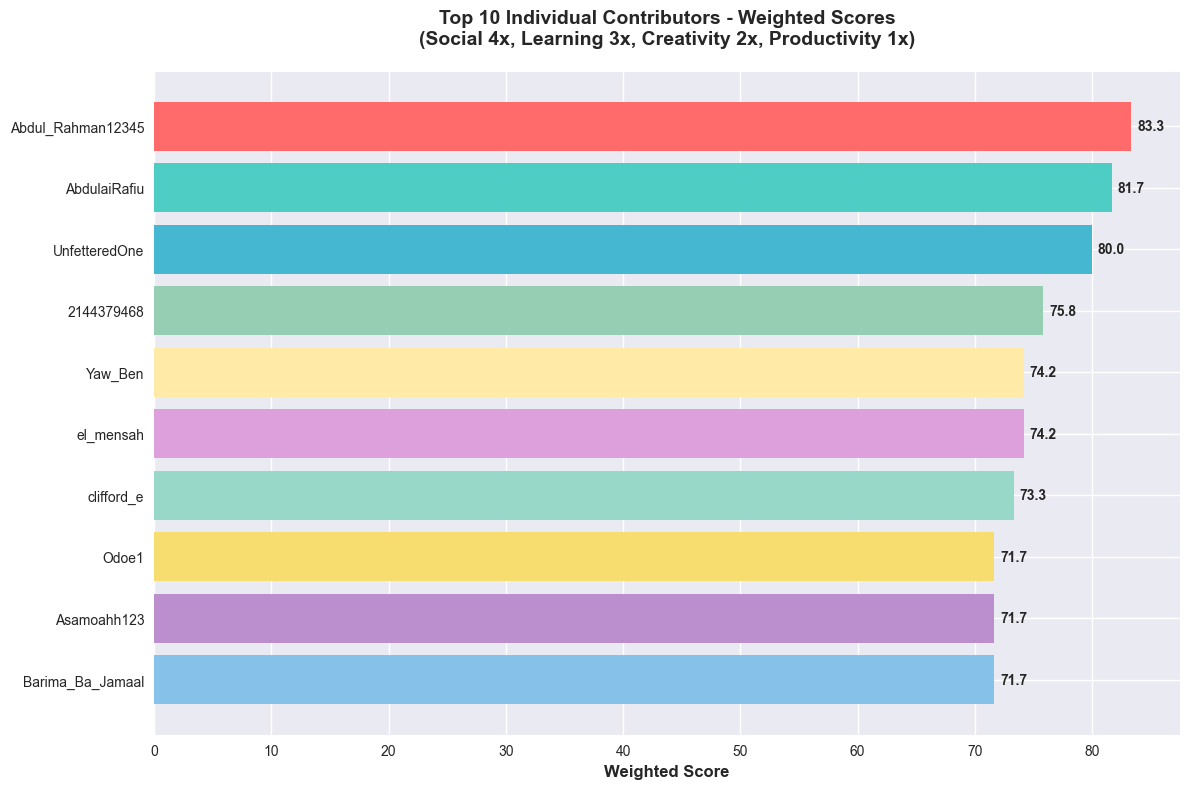

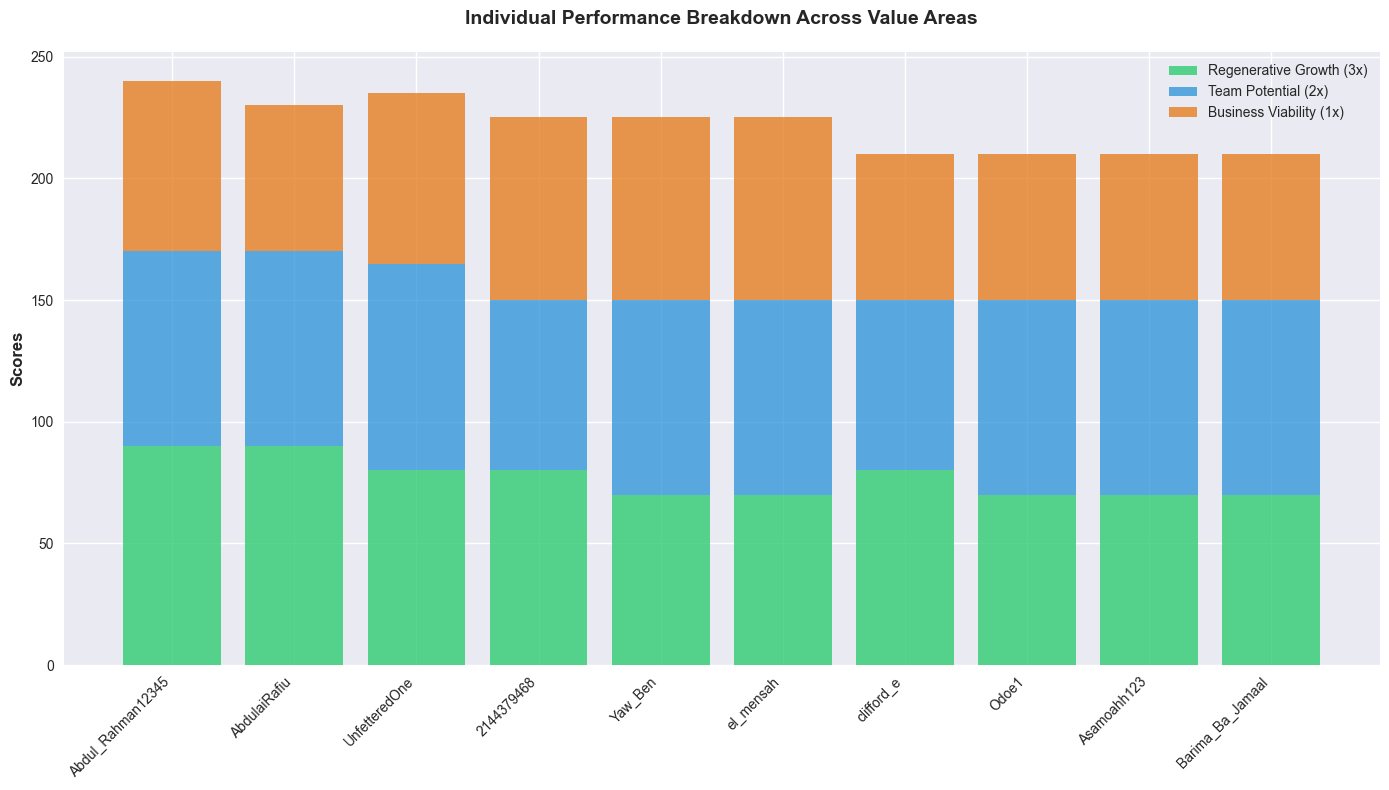

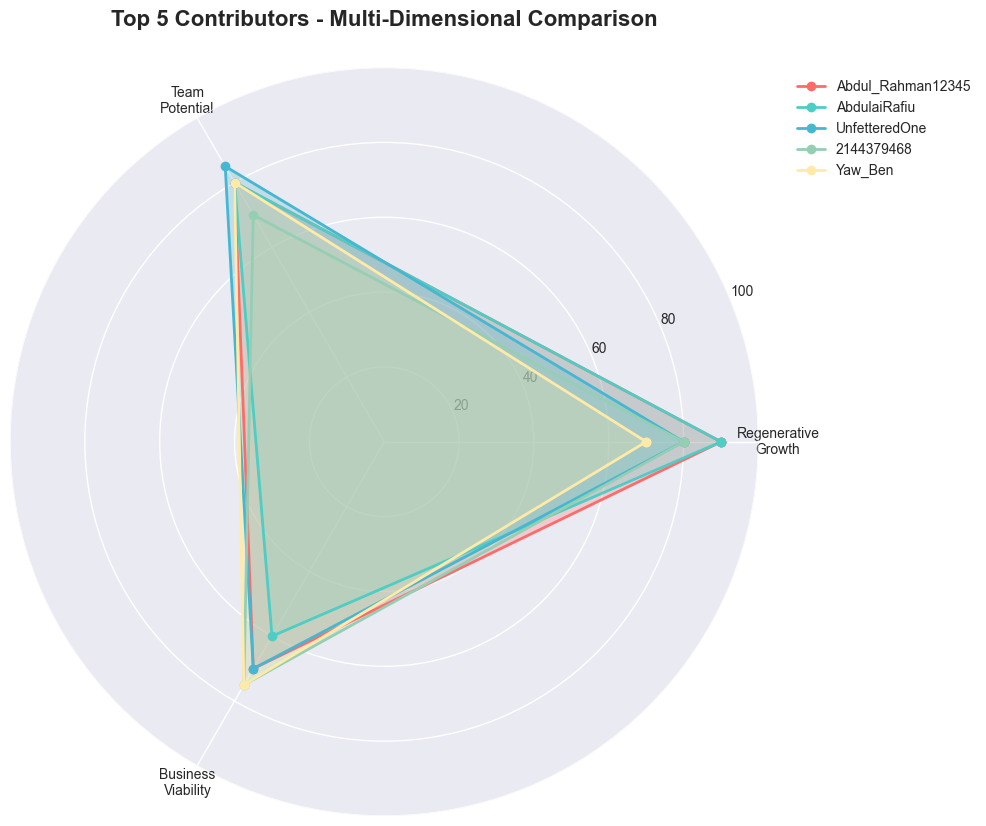


🏆 Generating team performance visualizations...


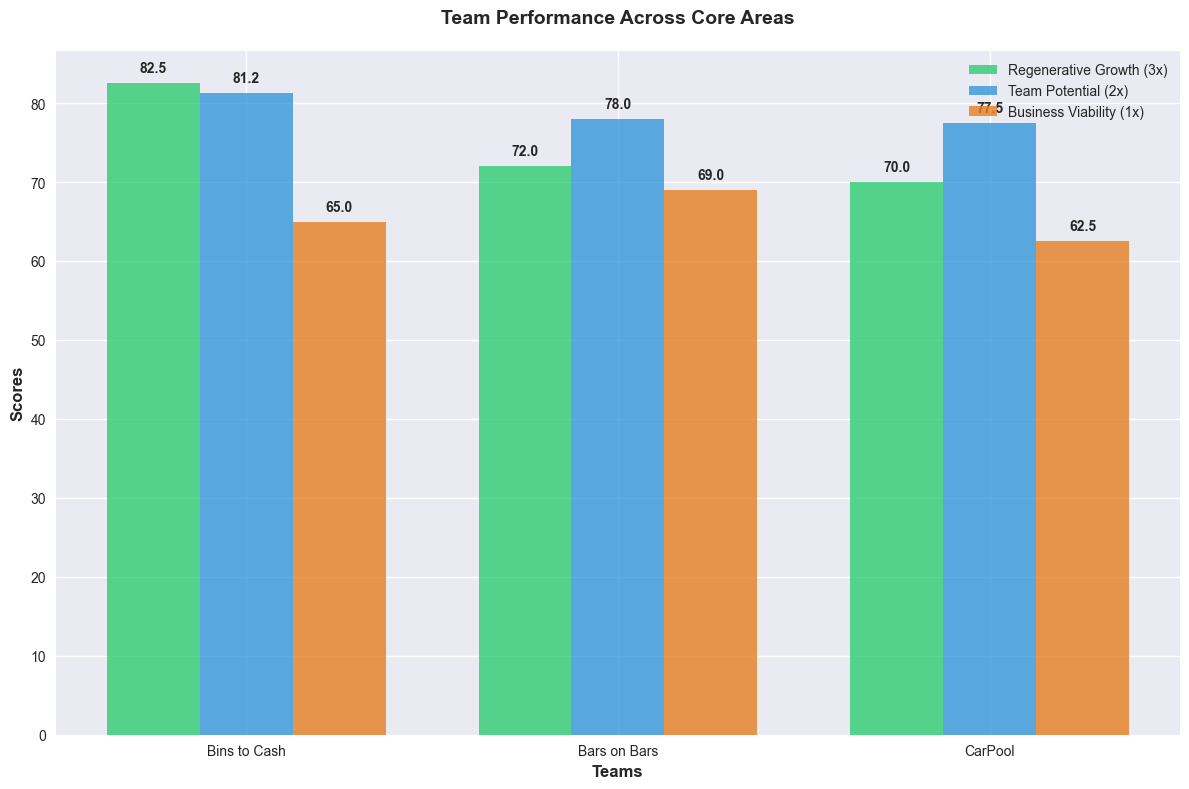

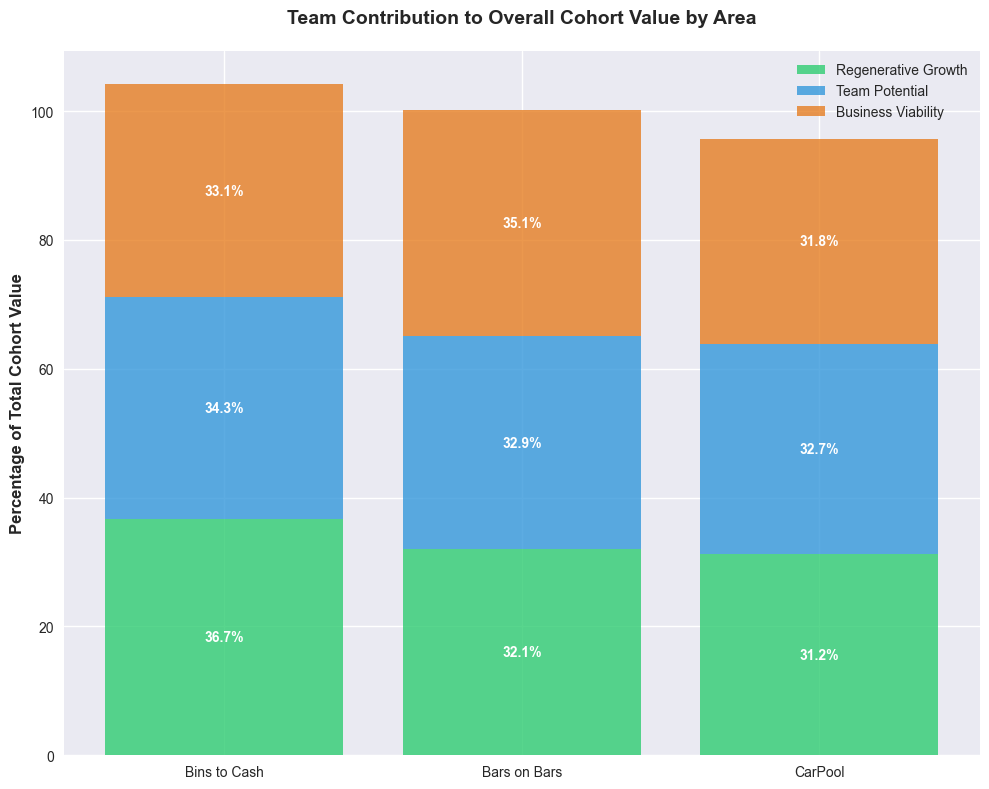

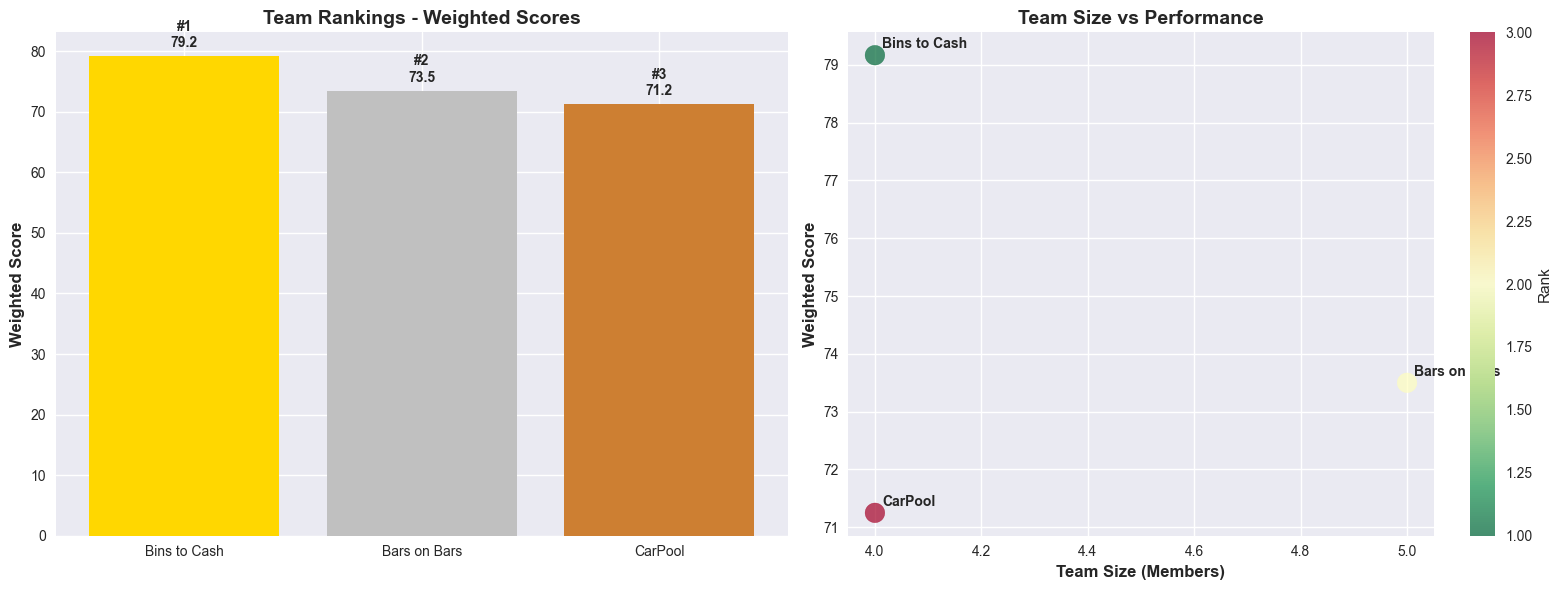


📈 Creating comprehensive evaluation dashboard...


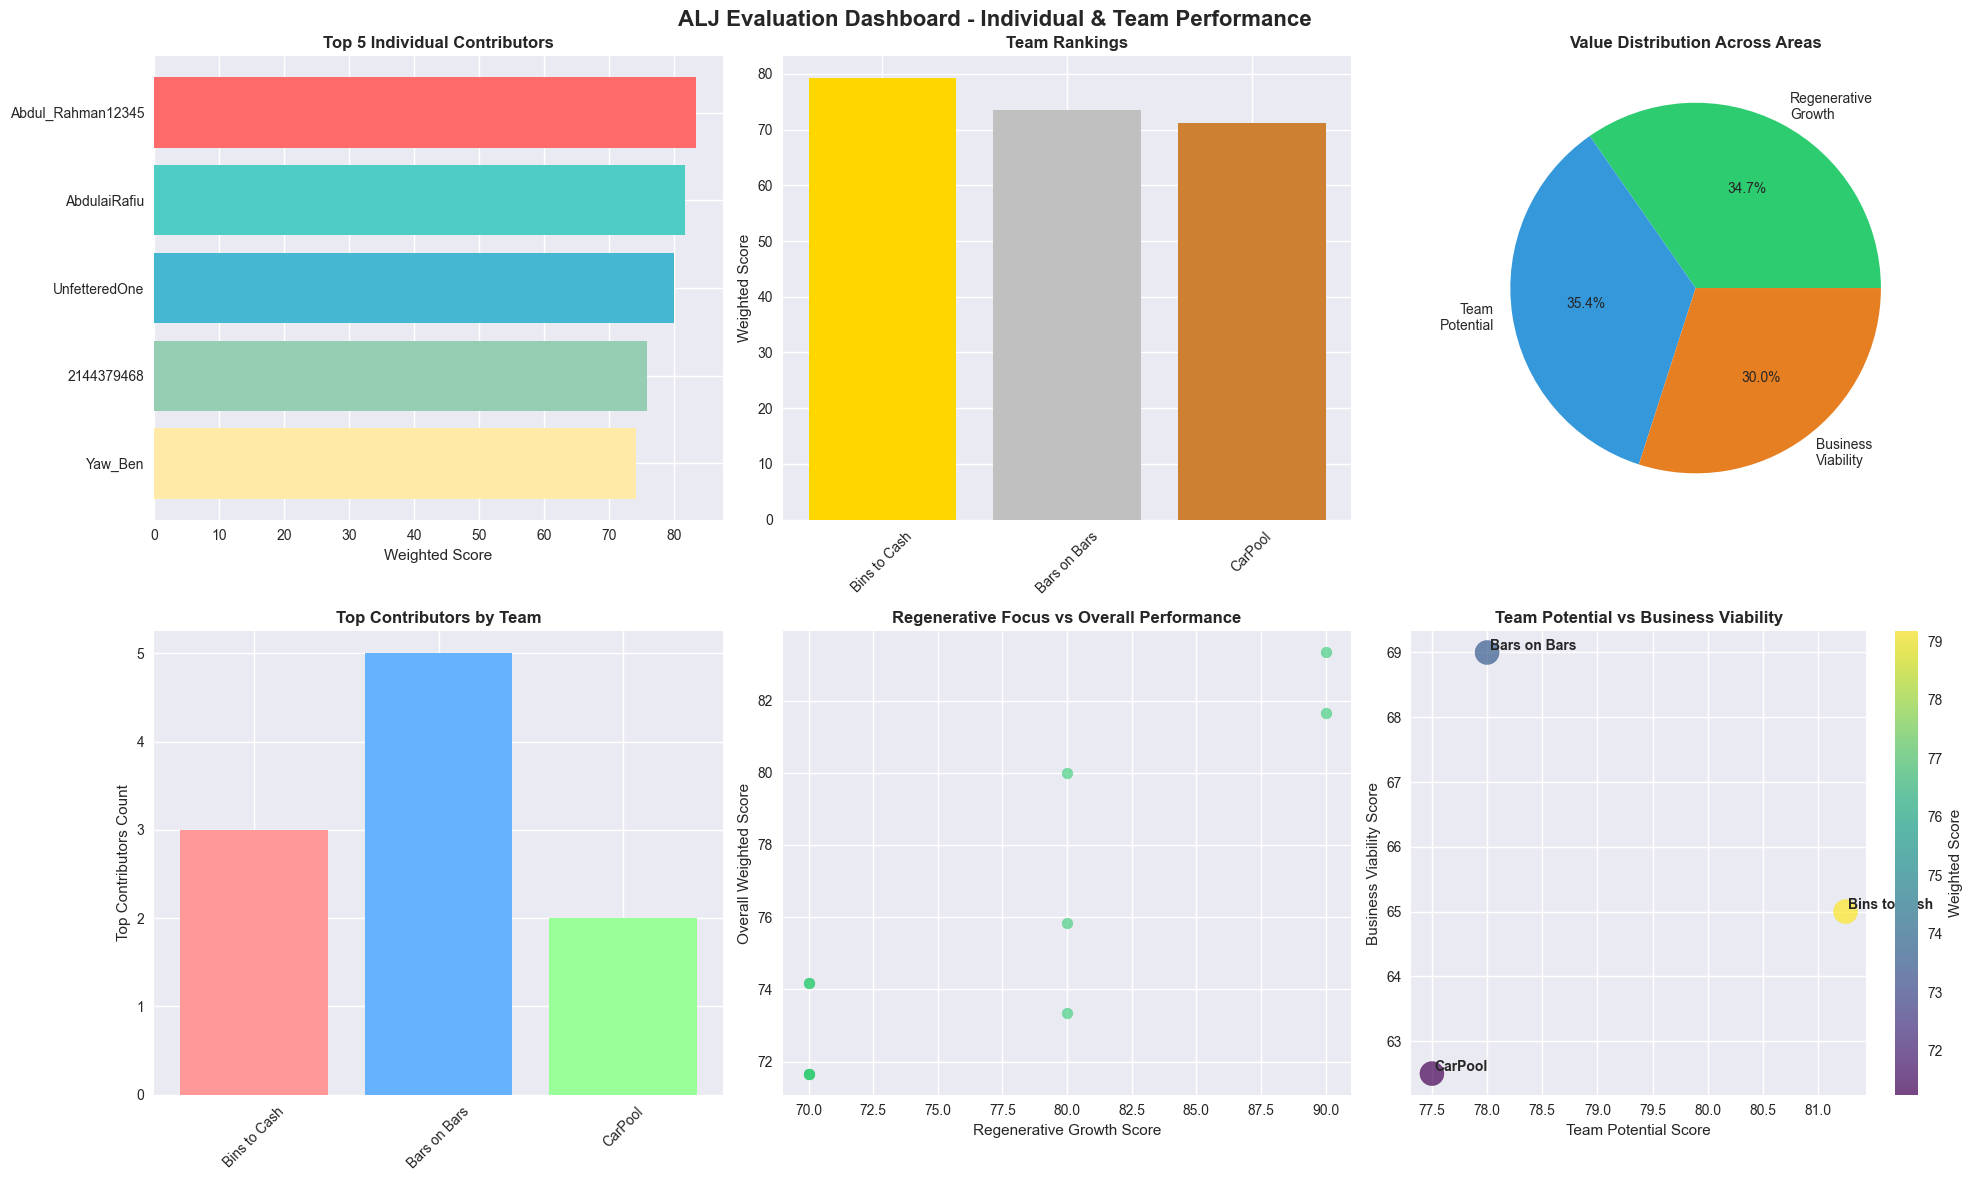


✅ All visualizations created successfully!

📋 Summary of charts created:
   • Individual weighted scores (horizontal bar)
   • Individual value area breakdown (stacked bar)
   • Top 5 multi-dimensional comparison (radar chart)
   • Team performance across areas (grouped bar)
   • Team contribution percentages (stacked percentage)
   • Team rankings with size analysis (dual chart)
   • Comprehensive evaluation dashboard (6-panel summary)


In [143]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Set style for better-looking plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def create_individual_rankings_visualizations(scores_df):
    """
    Creates multiple visualizations for individual participant rankings
    """
    
    # Calculate weighted scores for individuals (matching your methodology)
    individual_scores = scores_df.copy()
    individual_scores['weighted_score'] = (
        individual_scores['regenerative_growth'] * 3 +
        individual_scores['team_potential'] * 2 +
        individual_scores['business_viability'] * 1
    ) / 6
    
    # Sort by weighted score
    top_individuals = individual_scores.sort_values('weighted_score', ascending=False).head(10)
    
    # 1. HORIZONTAL BAR CHART - Individual Weighted Scores
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(top_individuals)), top_individuals['weighted_score'], 
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7', 
                           '#DDA0DD', '#98D8C8', '#F7DC6F', '#BB8FCE', '#85C1E9'])
    
    plt.yticks(range(len(top_individuals)), top_individuals['participant'])
    plt.xlabel('Weighted Score', fontsize=12, fontweight='bold')
    plt.title('Top 10 Individual Contributors - Weighted Scores\n(Social 4x, Learning 3x, Creativity 2x, Productivity 1x)', 
              fontsize=14, fontweight='bold', pad=20)
    plt.gca().invert_yaxis()
    
    # Add score labels on bars
    for i, (bar, score) in enumerate(zip(bars, top_individuals['weighted_score'])):
        plt.text(score + 0.5, bar.get_y() + bar.get_height()/2, f'{score:.1f}', 
                va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 2. STACKED BAR CHART - Individual Value Area Breakdown
    plt.figure(figsize=(14, 8))
    
    # Prepare data for stacking
    areas = ['regenerative_growth', 'team_potential', 'business_viability']
    area_labels = ['Regenerative Growth (3x)', 'Team Potential (2x)', 'Business Viability (1x)']
    colors = ['#2ECC71', '#3498DB', '#E67E22']
    
    bottom = np.zeros(len(top_individuals))
    
    for i, (area, label, color) in enumerate(zip(areas, area_labels, colors)):
        plt.bar(range(len(top_individuals)), top_individuals[area], 
                bottom=bottom, label=label, color=color, alpha=0.8)
        bottom += top_individuals[area]
    
    plt.xticks(range(len(top_individuals)), top_individuals['participant'], rotation=45, ha='right')
    plt.ylabel('Scores', fontsize=12, fontweight='bold')
    plt.title('Individual Performance Breakdown Across Value Areas', fontsize=14, fontweight='bold', pad=20)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()
    
    # 3. RADAR CHART - Top 5 Individuals Comparison
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # Prepare data for radar chart
    top_5 = top_individuals.head(5)
    categories = ['Regenerative\nGrowth', 'Team\nPotential', 'Business\nViability']
    
    # Number of variables
    N = len(categories)
    
    # Angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    colors_radar = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']
    
    for i, (_, person) in enumerate(top_5.iterrows()):
        values = [person['regenerative_growth'], person['team_potential'], person['business_viability']]
        values += values[:1]  # Complete the circle
        
        ax.plot(angles, values, 'o-', linewidth=2, label=person['participant'], color=colors_radar[i])
        ax.fill(angles, values, alpha=0.25, color=colors_radar[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_ylim(0, 100)
    ax.set_title('Top 5 Contributors - Multi-Dimensional Comparison', size=16, fontweight='bold', pad=30)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
    plt.tight_layout()
    plt.show()
    
    return top_individuals

def create_team_rankings_visualizations(team_scores):
    """
    Creates multiple visualizations for team rankings
    """
    
    # 1. GROUPED BAR CHART - Team Scores Across Areas
    fig, ax = plt.subplots(figsize=(12, 8))
    
    x = np.arange(len(team_scores))
    width = 0.25
    
    bars1 = ax.bar(x - width, team_scores['regenerative_growth'], width, 
                   label='Regenerative Growth (3x)', color='#2ECC71', alpha=0.8)
    bars2 = ax.bar(x, team_scores['team_potential'], width, 
                   label='Team Potential (2x)', color='#3498DB', alpha=0.8)
    bars3 = ax.bar(x + width, team_scores['business_viability'], width, 
                   label='Business Viability (1x)', color='#E67E22', alpha=0.8)
    
    ax.set_xlabel('Teams', fontsize=12, fontweight='bold')
    ax.set_ylabel('Scores', fontsize=12, fontweight='bold')
    ax.set_title('Team Performance Across Core Areas', fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(team_scores['team'])
    ax.legend()
    
    # Add value labels on bars
    for bars in [bars1, bars2, bars3]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 1,
                   f'{height:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 2. STACKED PERCENTAGE CHART - Team Contribution to Overall Value
    plt.figure(figsize=(10, 8))
    
    areas = ['regenerative_growth', 'team_potential', 'business_viability']
    area_labels = ['Regenerative Growth', 'Team Potential', 'Business Viability']
    colors = ['#2ECC71', '#3498DB', '#E67E22']
    
    # Calculate percentages
    percentages = {}
    for area in areas:
        total = team_scores[area].sum()
        percentages[area] = (team_scores[area] / total * 100).values
    
    bottom = np.zeros(len(team_scores))
    
    for i, (area, label, color) in enumerate(zip(areas, area_labels, colors)):
        plt.bar(team_scores['team'], percentages[area], bottom=bottom, 
                label=label, color=color, alpha=0.8)
        
        # Add percentage labels
        for j, (team, pct) in enumerate(zip(team_scores['team'], percentages[area])):
            if pct > 5:  # Only show label if percentage is significant
                plt.text(j, bottom[j] + pct/2, f'{pct:.1f}%', 
                        ha='center', va='center', fontweight='bold', color='white')
        
        bottom += percentages[area]
    
    plt.ylabel('Percentage of Total Cohort Value', fontsize=12, fontweight='bold')
    plt.title('Team Contribution to Overall Cohort Value by Area', fontsize=14, fontweight='bold', pad=20)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 3. WEIGHTED SCORE COMPARISON WITH RANKING
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left plot: Weighted scores
    bars = ax1.bar(team_scores['team'], team_scores['weighted_total'], 
                   color=['#FFD700', '#C0C0C0', '#CD7F32'])  # Gold, Silver, Bronze
    ax1.set_ylabel('Weighted Score', fontsize=12, fontweight='bold')
    ax1.set_title('Team Rankings - Weighted Scores', fontsize=14, fontweight='bold')
    
    # Add score and rank labels
    for i, (bar, score, rank) in enumerate(zip(bars, team_scores['weighted_total'], team_scores['rank'])):
        ax1.text(bar.get_x() + bar.get_width()/2, score + 1, 
                f'#{rank}\n{score:.1f}', ha='center', va='bottom', fontweight='bold')
    
    # Right plot: Member count vs performance
    scatter = ax2.scatter(team_scores['member_count'], team_scores['weighted_total'], 
                         s=200, c=team_scores['rank'], cmap='RdYlGn_r', alpha=0.7)
    
    for i, team in enumerate(team_scores['team']):
        ax2.annotate(team, (team_scores.iloc[i]['member_count'], team_scores.iloc[i]['weighted_total']),
                    xytext=(5, 5), textcoords='offset points', fontweight='bold')
    
    ax2.set_xlabel('Team Size (Members)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Weighted Score', fontsize=12, fontweight='bold')
    ax2.set_title('Team Size vs Performance', fontsize=14, fontweight='bold')
    
    plt.colorbar(scatter, ax=ax2, label='Rank')
    plt.tight_layout()
    plt.show()

def create_combined_summary_dashboard(individual_top, team_scores):
    """
    Creates a comprehensive dashboard combining individual and team insights
    """
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Top individuals (top left)
    ax1 = plt.subplot(2, 3, 1)
    top_5_ind = individual_top.head(5)
    bars = plt.barh(range(len(top_5_ind)), top_5_ind['weighted_score'], 
                    color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'])
    plt.yticks(range(len(top_5_ind)), top_5_ind['participant'])
    plt.xlabel('Weighted Score')
    plt.title('Top 5 Individual Contributors', fontweight='bold')
    plt.gca().invert_yaxis()
    
    # 2. Team rankings (top middle)
    ax2 = plt.subplot(2, 3, 2)
    bars = plt.bar(team_scores['team'], team_scores['weighted_total'], 
                   color=['#FFD700', '#C0C0C0', '#CD7F32'])
    plt.ylabel('Weighted Score')
    plt.title('Team Rankings', fontweight='bold')
    plt.xticks(rotation=45)
    
    # 3. Value area distribution (top right)
    ax3 = plt.subplot(2, 3, 3)
    area_totals = [
        individual_top['regenerative_growth'].sum(),
        individual_top['team_potential'].sum(), 
        individual_top['business_viability'].sum()
    ]
    plt.pie(area_totals, labels=['Regenerative\nGrowth', 'Team\nPotential', 'Business\nViability'], 
            autopct='%1.1f%%', colors=['#2ECC71', '#3498DB', '#E67E22'])
    plt.title('Value Distribution Across Areas', fontweight='bold')
    
    # 4. Team composition (bottom left)
    ax4 = plt.subplot(2, 3, 4)
    team_member_data = []
    for team in team_scores['team']:
        team_individuals = individual_top[individual_top['team'] == team]
        team_member_data.append(len(team_individuals))
    
    plt.bar(team_scores['team'], team_member_data, color=['#FF9999', '#66B2FF', '#99FF99'])
    plt.ylabel('Top Contributors Count')
    plt.title('Top Contributors by Team', fontweight='bold')
    plt.xticks(rotation=45)
    
    # 5. Performance correlation (bottom middle)
    ax5 = plt.subplot(2, 3, 5)
    plt.scatter(individual_top['regenerative_growth'], individual_top['weighted_score'], 
               alpha=0.6, s=60, color='#2ECC71')
    plt.xlabel('Regenerative Growth Score')
    plt.ylabel('Overall Weighted Score')
    plt.title('Regenerative Focus vs Overall Performance', fontweight='bold')
    
    # 6. Team potential vs business viability (bottom right)
    ax6 = plt.subplot(2, 3, 6)
    scatter = plt.scatter(team_scores['team_potential'], team_scores['business_viability'], 
                         s=300, c=team_scores['weighted_total'], cmap='viridis', alpha=0.7)
    
    for i, team in enumerate(team_scores['team']):
        plt.annotate(team, (team_scores.iloc[i]['team_potential'], team_scores.iloc[i]['business_viability']),
                    xytext=(2, 2), textcoords='offset points', fontweight='bold')
    
    plt.xlabel('Team Potential Score')
    plt.ylabel('Business Viability Score')
    plt.title('Team Potential vs Business Viability', fontweight='bold')
    plt.colorbar(scatter, label='Weighted Score')
    
    plt.suptitle('ALJ Evaluation Dashboard - Individual & Team Performance', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

# --- EXECUTE ALL VISUALIZATIONS ---
print("🎨 Creating comprehensive visualizations for ALJ evaluation...")

# Create individual rankings visualizations
print("\n📊 Generating individual contributor visualizations...")
top_individuals = create_individual_rankings_visualizations(scores_df)

# Create team rankings visualizations  
print("\n🏆 Generating team performance visualizations...")
create_team_rankings_visualizations(basic_scores)

# Create combined dashboard
print("\n📈 Creating comprehensive evaluation dashboard...")
create_combined_summary_dashboard(top_individuals, basic_scores)

print("\n✅ All visualizations created successfully!")
print("\n📋 Summary of charts created:")
print("   • Individual weighted scores (horizontal bar)")
print("   • Individual value area breakdown (stacked bar)")
print("   • Top 5 multi-dimensional comparison (radar chart)")
print("   • Team performance across areas (grouped bar)")
print("   • Team contribution percentages (stacked percentage)")
print("   • Team rankings with size analysis (dual chart)")
print("   • Comprehensive evaluation dashboard (6-panel summary)")
